In [ ]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [2]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/NLPCA'
pict_results_path = os.environ['PACKAGE_OUTPUT']+'/NLPCA/picts'
files_results_path = os.environ['PACKAGE_OUTPUT']+'/NLPCA/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+
                                  'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

Time to import all libraries: 2.40802764893e-05 seconds
Time to read data file: 1.53720188141 seconds


In [3]:
# Get data in correct format
from keras.utils import np_utils

# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)

all_data = all_data.transpose()

# turn targets in sparse mode
trgt_sparse = np_utils.to_categorical(all_trgt)

Using Theano backend.
/home/natmourajr/.virtualenvs/sonarsatigny/lib/python2.7/site-packages/keras/utils/np_utils.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
/home/natmourajr/.virtualenvs/sonarsatigny/lib/python2.7/site-packages/keras/utils/np_utils.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


Extract Proccess 

![Image of Yaktocat](http://www.nlpca.org/fig_NLPCA_bottleneck_autoassociative_autoencoder_neural_network.png)



In [ ]:
# Train Process
from Functions import LogFunctions as log

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge

import numpy.linalg as la

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry(package_name="PreProcessing",analysis_name='NLPCA')

m_time = time.time()

# Create a train information file
n_folds = 10
n_inits = 10
n_nlpcas = 30
norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['n_nlpcas'] = n_nlpcas
train_info['norm'] = norm

train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
classifiers_name = result_analysis_path+'/classifiers_files'+'/'+date+'_classifiers'
nlpcas_file_name = result_analysis_path+'/output_files'+'/'+date+'_nlpcas'

from sklearn import cross_validation
from sklearn import preprocessing

CVO = cross_validation.StratifiedKFold(all_trgt, train_info['n_folds'])
CVO = list(CVO)
train_info['CVO'] = CVO

joblib.dump([train_info],train_info_name,compress=9)

# train classifiers
nlpca_extractor = {}
trn_desc = {}
nlpca = {}

for ifold in range(train_info['n_folds']):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
       
    nlpca_extractor[ifold] = {}
    trn_desc[ifold] = {}

    
    for inlpca in range(train_info['n_nlpcas']):
        best_init = 0
        best_loss = 999
        
        
        for i_init in range(train_info['n_inits']):
            print ('Fold: %i of %i - NLPCA: %i of %i - Init: %i of %i'
                   %(ifold+1, train_info['n_folds'],
                     inlpca+1, train_info['n_nlpcas'],
                     i_init+1,train_info['n_inits']))
            model = Sequential()
            model.add(Dense(all_data.shape[1],
                            input_dim=all_data.shape[1], 
                            init='identity',trainable=False))
            model.add(Activation('linear'))
            model.add(Dense(inlpca+1, input_dim=all_data.shape[1], init='uniform'))
            model.add(Activation('tanh'))
            model.add(Dense(1,init='uniform'))
            model.add(Activation('tanh'))
            model.add(Dense(inlpca+1,init='uniform'))
            model.add(Activation('tanh'))
            model.add(Dense(all_data.shape[1],init='uniform'))
            model.add(Activation('linear'))
            
            
            sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            model.compile(loss='mean_squared_error', optimizer=sgd
                          ,metrics=['accuracy'])
            
            earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=25,
                                                    verbose=0, 
                                                    mode='auto')
            # Train model
            init_trn_desc = model.fit(norm_all_data[train_id], norm_all_data[train_id], 
                                      nb_epoch=50, 
                                      batch_size=8,
                                      callbacks=[earlyStopping], 
                                      verbose=0,
                                      validation_data=(norm_all_data[test_id],
                                                       norm_all_data[test_id]),
                                      shuffle=True)
            if np.min(init_trn_desc.history['val_loss']) < best_loss:
                best_init = i_init
                best_loss = np.min(init_trn_desc.history['val_loss'])
                nlpca_extractor[ifold][inlpca] = model
                trn_desc[ifold][inlpca] = init_trn_desc
                
        nlpca_extractor[ifold][inlpca].save('%s_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,ifold,inlpca))  
                

Fold: 1 of 10 - NLPCA: 1 of 30 - Init: 1 of 10


In [3]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="PreProcessing")
print log_entries

{0: {'date': '2016_09_19_19_13_02', 'package': 'PCALinear'}, 1: {'date': '2016_09_21_19_25_31', 'package': 'NLPCA'}, 2: {'date': '2016_09_21_19_25_48', 'package': 'NLPCA'}, 3: {'date': '2016_09_21_20_14_31', 'package': 'NLPCA'}, 4: {'date': '2016_09_21_20_25_54', 'package': 'NLPCA'}, 5: {'date': '2016_09_21_20_26_05', 'package': 'NLPCA'}, 6: {'date': '2016_09_21_20_26_12', 'package': 'NLPCA'}, 7: {'date': '2016_09_21_20_30_53', 'package': 'NLPCA'}, 8: {'date': '2016_09_21_20_35_59', 'package': 'NLPCA'}, 9: {'date': '2016_09_21_20_36_30', 'package': 'NLPCA'}, 10: {'date': '2016_09_21_20_40_38', 'package': 'NLPCA'}, 11: {'date': '2016_09_21_20_56_00', 'package': 'NLPCA'}}


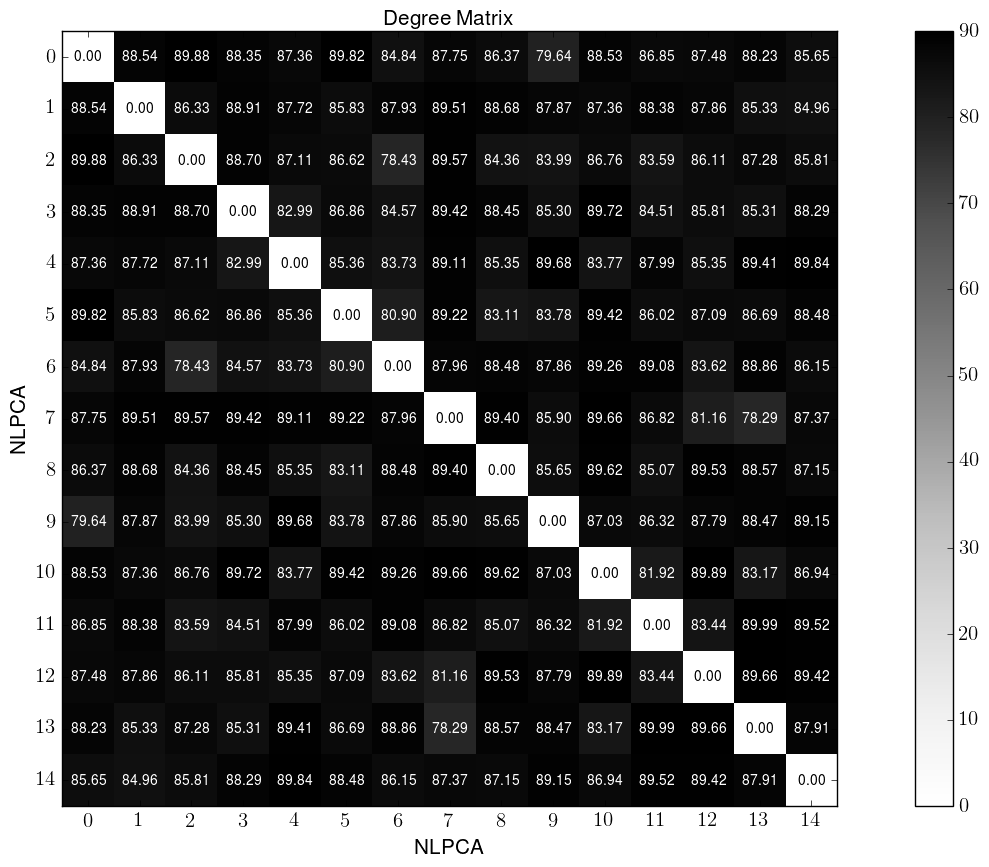

In [121]:
# Plot degree between each NLPCA

from keras.models import load_model

import numpy.linalg
choose_date = '2016_09_21_20_56_00'
choose_fold = 0


nlpcas_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_nlpcas'

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'

train_info = joblib.load(train_info_name)
train_info = train_info[0]

choose_nlpca = 15

nlpca_model = load_model('%s_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,choose_fold,choose_nlpca))

nlpca_matrix = nlpca_model.layers[2].get_weights()[0]

degree_matrix = np.zeros([choose_nlpca,choose_nlpca])

for inlpca in range(choose_nlpca):
    for jnlpca in range(choose_nlpca):
        degree = (np.inner(nlpca_matrix[:,inlpca].T,nlpca_matrix[:,jnlpca].T)/
                 (np.linalg.norm(nlpca_matrix[:,inlpca])*
                  np.linalg.norm(nlpca_matrix[:,jnlpca])))
        
        degree = round(degree.real,4)
        degree = np.arccos(degree)
        degree = np.degrees(degree)
        if degree > 90 and degree < 180:
            degree = degree - 180
        if degree > 180 and degree < 270:
            degree = degree - 180
        
        degree_matrix[inlpca,jnlpca] = np.abs(degree)
        
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im =ax.imshow(degree_matrix, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 90.0))
width, height = degree_matrix.shape

for x in xrange(width):
    for y in xrange(height):
        if degree_matrix[x][y] < 45.:
            ax.annotate('%1.2f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.2f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Degree Matrix',fontweight='bold',fontsize=15)
ax.set_ylabel('#NLPCA',fontweight='bold',fontsize=15)
ax.set_xlabel('#NLPCA',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(choose_nlpca)   
ax.xaxis.set_ticks(tick_marks)
ax.yaxis.set_ticks(tick_marks)

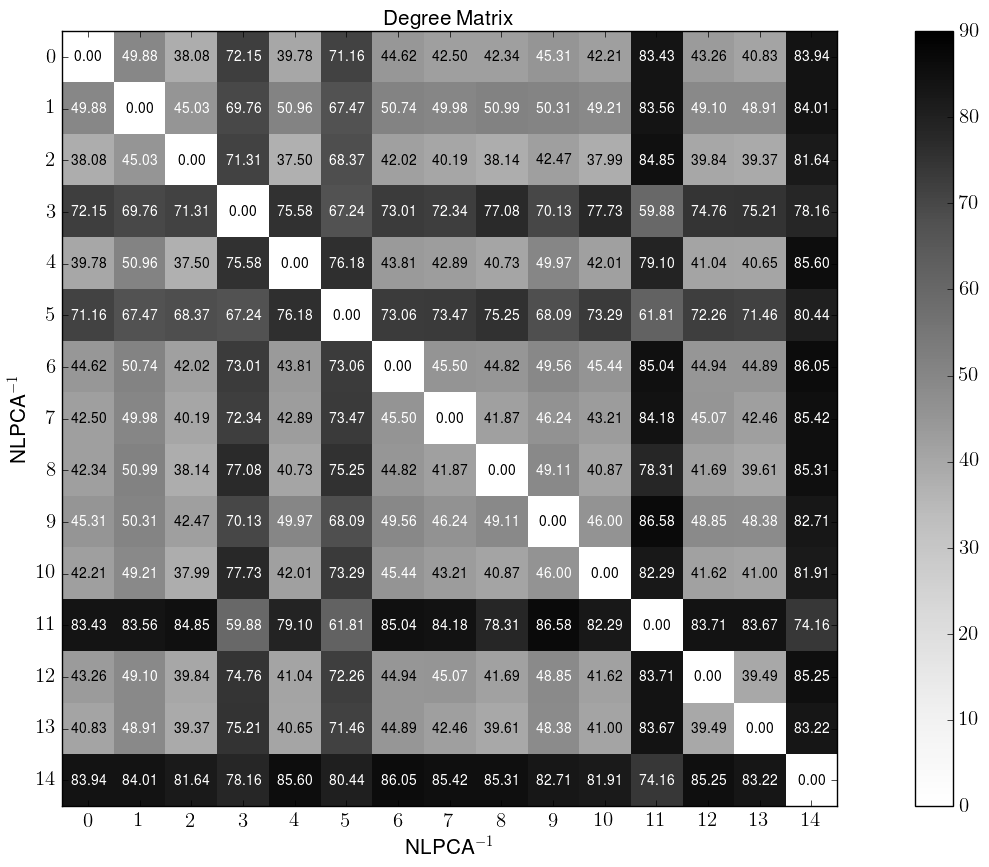

In [120]:
# Plot degree between each NLPCA

from keras.models import load_model

import numpy.linalg
choose_date = '2016_09_21_20_56_00'
choose_fold = 0


nlpcas_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_nlpcas'

train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'

train_info = joblib.load(train_info_name)
train_info = train_info[0]

choose_nlpca = 15

nlpca_model = load_model('%s_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,choose_fold,choose_nlpca))

nlpca_matrix = nlpca_model.layers[8].get_weights()[0].T

degree_matrix = np.zeros([choose_nlpca,choose_nlpca])

for inlpca in range(choose_nlpca):
    for jnlpca in range(choose_nlpca):
        degree = (np.inner(nlpca_matrix[:,inlpca].T,nlpca_matrix[:,jnlpca].T)/
                 (np.linalg.norm(nlpca_matrix[:,inlpca])*
                  np.linalg.norm(nlpca_matrix[:,jnlpca])))
        
        degree = round(degree.real,4)
        degree = np.arccos(degree)
        degree = np.degrees(degree)
        if degree > 90 and degree < 180:
            degree = degree - 180
        if degree > 180 and degree < 270:
            degree = degree - 180
        
        degree_matrix[inlpca,jnlpca] = np.abs(degree)
        
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im =ax.imshow(degree_matrix, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 90.0))
width, height = degree_matrix.shape

for x in xrange(width):
    for y in xrange(height):
        if degree_matrix[x][y] < 45.:
            ax.annotate('%1.2f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.2f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Degree Matrix',fontweight='bold',fontsize=15)
ax.set_ylabel(r'#NLPCA^{-1}',fontweight='bold',fontsize=15)
ax.set_xlabel(r'#NLPCA^{-1}',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(choose_nlpca)   
ax.xaxis.set_ticks(tick_marks)
ax.yaxis.set_ticks(tick_marks)



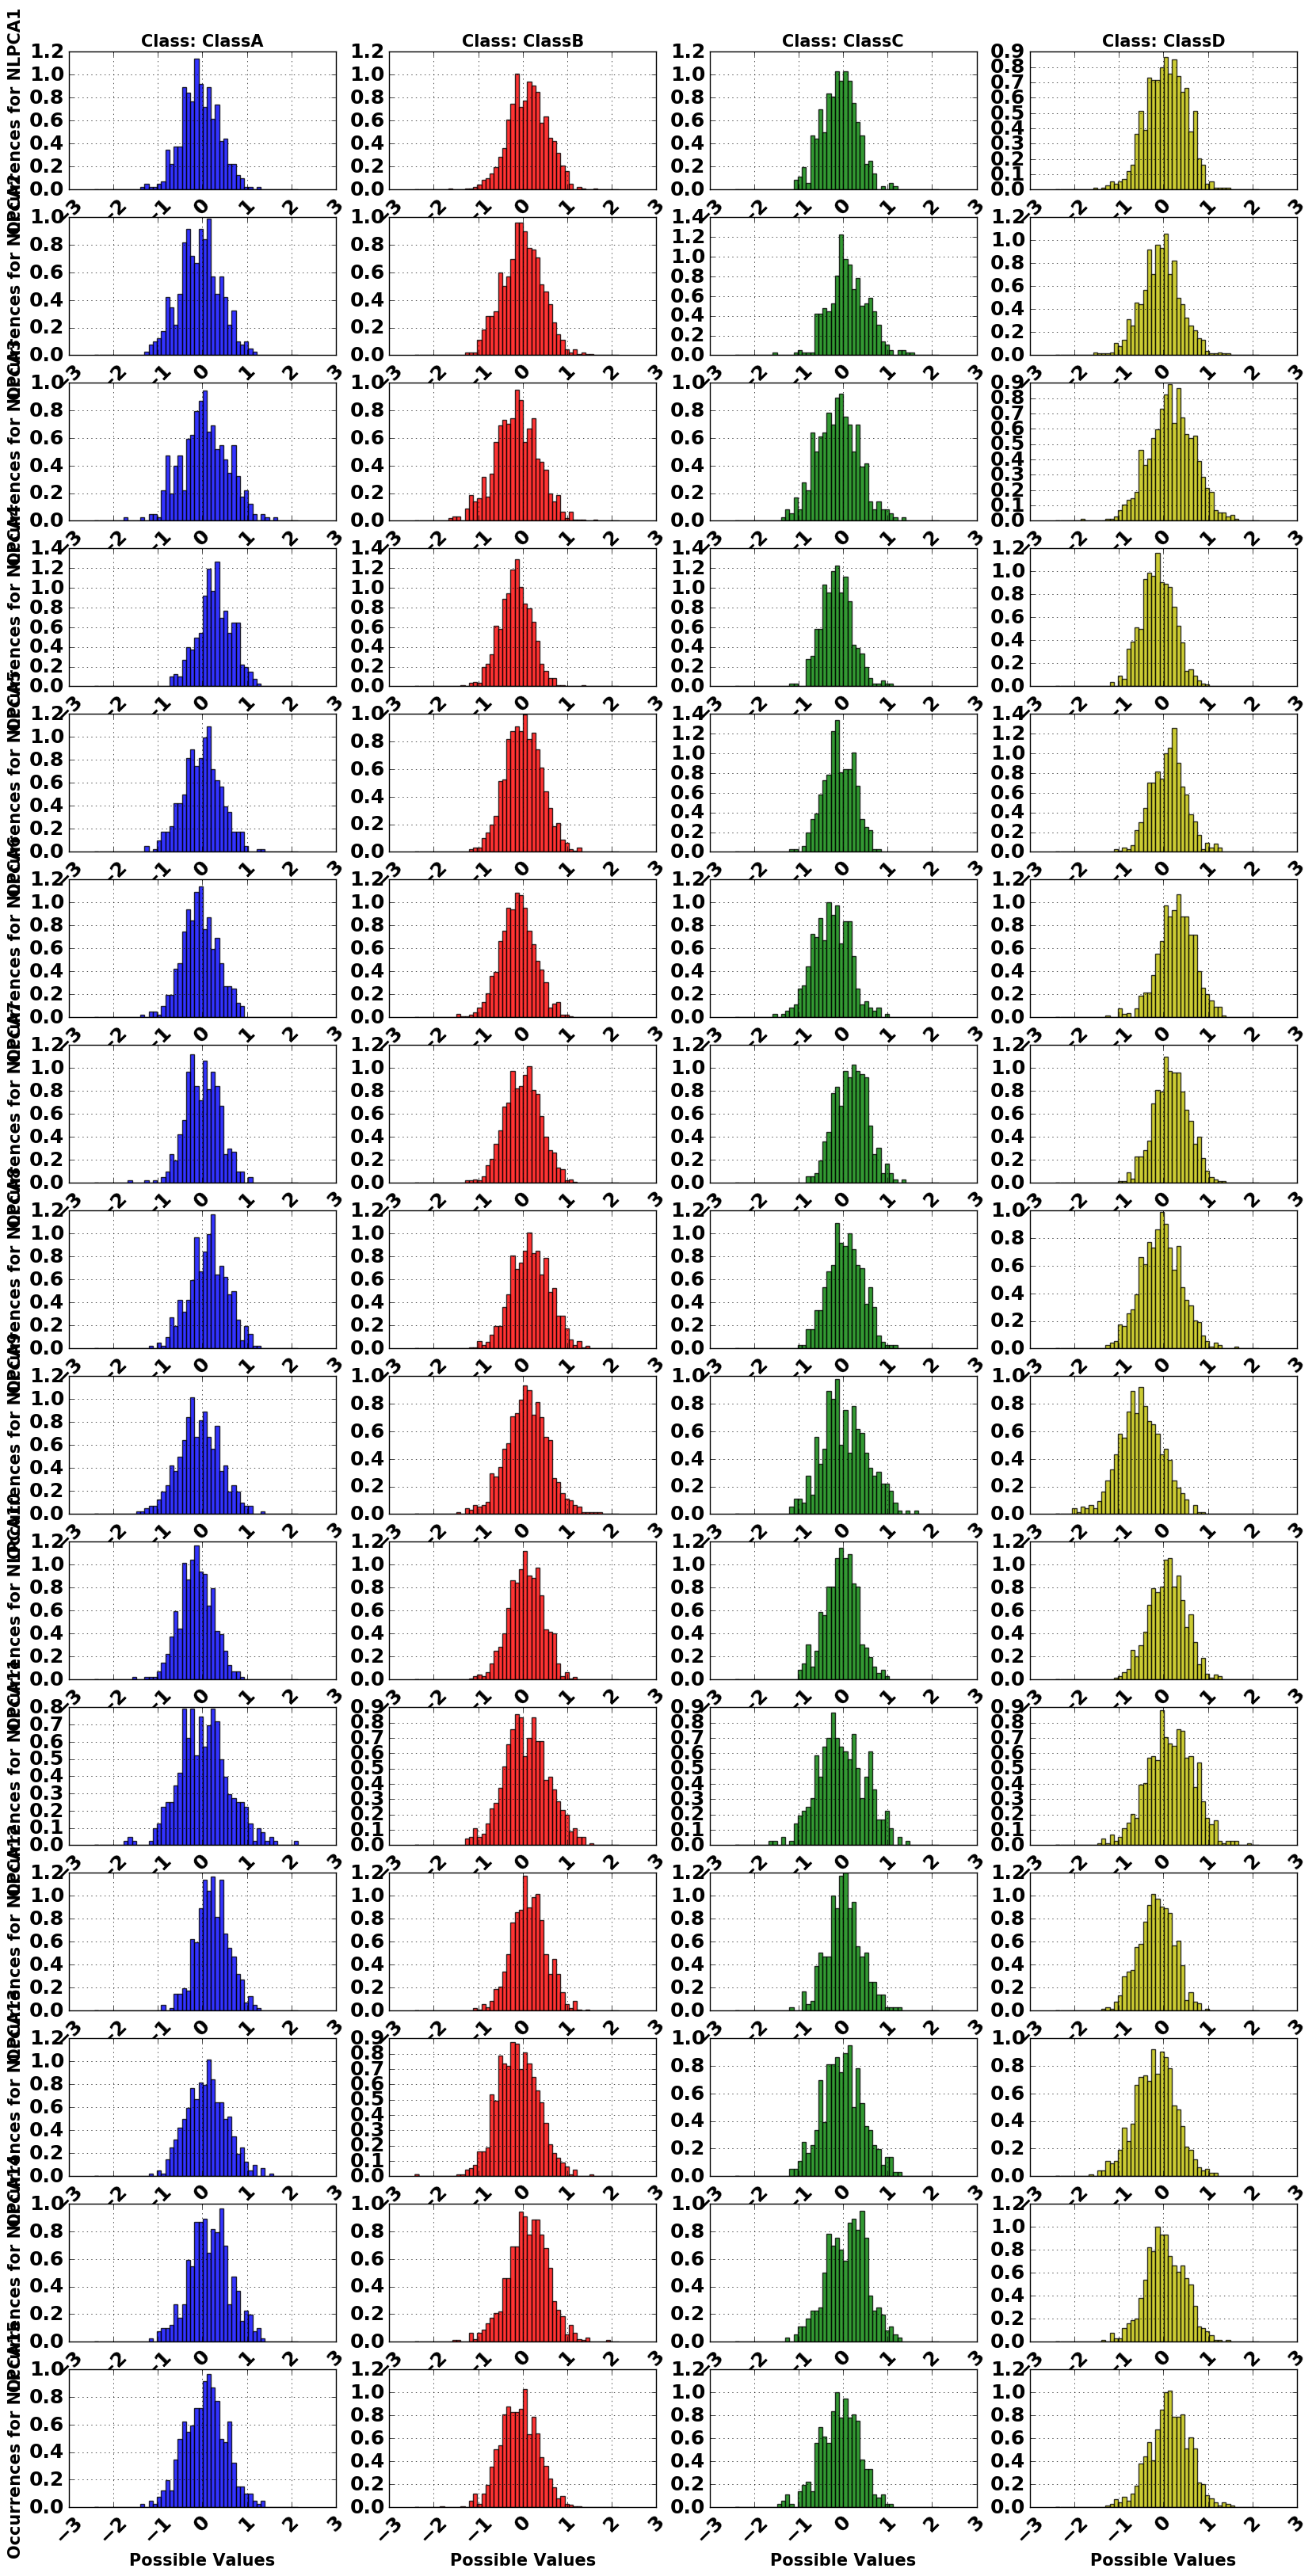

In [27]:
# Analysis Process
# Plot Class Distribution in each NLPCA
from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import load_model

choose_date = '2016_09_21_20_56_00'
choose_fold = 0
n_nlpca_plots = 15
n_classes = 4

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

choose_nlpca = 29
bins = np.linspace(0,choose_nlpca-1,choose_nlpca)

fig, ax = plt.subplots(figsize=(20,40),nrows=n_nlpca_plots, ncols=n_classes)
class_labels=["ClassA", "ClassB", "ClassC","ClassD"]
m_colors = ['b', 'r', 'g', 'y']

n_rows = n_nlpca_plots
n_columns = n_classes

irow = 0
icolumn = 0

train_id, test_id = train_info['CVO'][choose_fold]

# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
    
norm_all_data = scaler.transform(all_data)

nlpcas_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_nlpcas'
    
nlpca_model = load_model('%s_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,choose_fold,choose_nlpca))

# get the output of an intermediate layer
from keras import backend as K

# with a Sequential model
get_layer_output = K.function([nlpca_model.layers[0].input],
                                  [nlpca_model.layers[2].output])
data_proj_nlpca = get_layer_output([norm_all_data])[0]


for inlpca in range(n_nlpca_plots):
    for iclass, class_label in enumerate(class_labels):
        plot_data = data_proj_nlpca[test_id]
        plot_trgt = all_trgt[test_id]
        
        n_bins = np.linspace(plot_data.min(),plot_data.max(),50)
        n, bins, patches = ax[irow,icolumn].hist(plot_data[plot_trgt==iclass,inlpca],bins=n_bins,
                                                      fc=m_colors[iclass],
                                                      alpha=0.8, normed=1)
        
        for tick in ax[irow,icolumn].get_xticklabels():
            tick.set_rotation(45)
        ax[irow,icolumn].grid()
        
        if irow == 0:
            ax[irow,icolumn].set_title('Class: %s'%(class_label),
                                  fontweight='bold',fontsize=15)
        if icolumn == 0:
            ax[irow,icolumn].set_ylabel('Occurrences for NLPCA%i'%(inlpca+1),fontweight='bold',fontsize=15)
        if irow == n_rows-1:
            ax[irow,icolumn].set_xlabel('Possible Values',fontweight='bold',fontsize=15)
        
        if icolumn+1 == n_columns:
            icolumn = 0
            irow = irow+1
        else:
            icolumn = icolumn+1


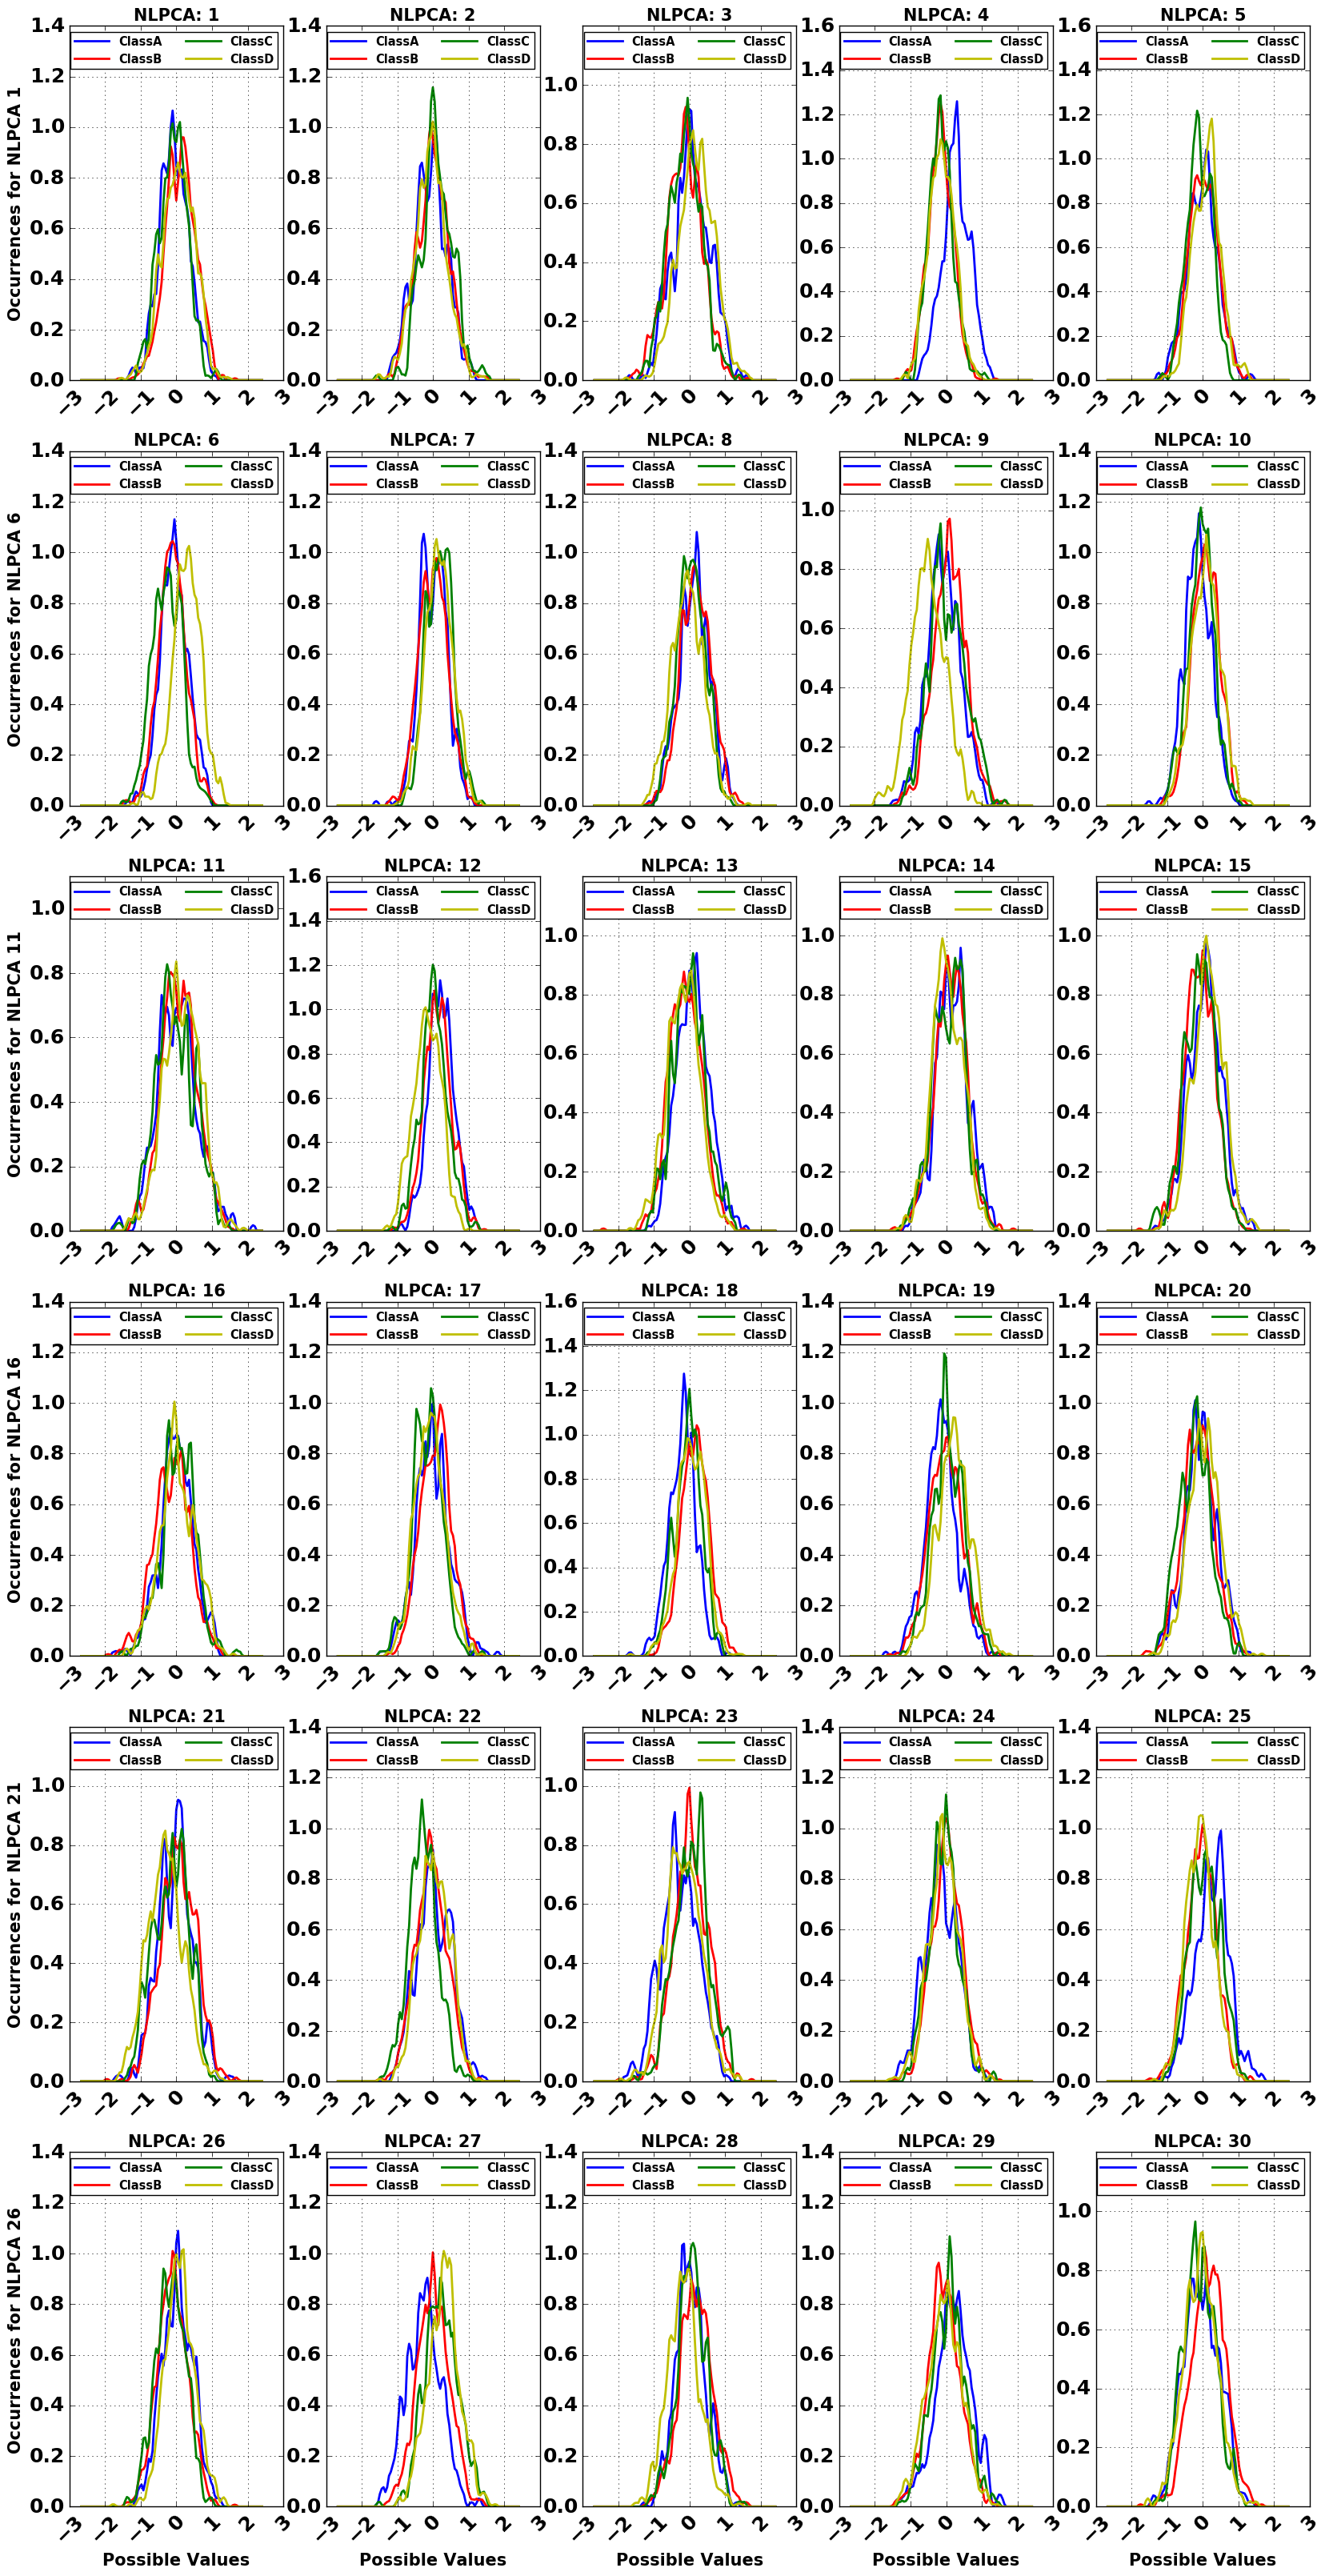

In [58]:
# Analysis Process
# Plot Class Distribution in each NLPCA
from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import load_model

choose_date = '2016_09_21_20_56_00'
choose_fold = 0
n_nlpca_plots = 30
choose_nlpca = 29

n_classes = 4

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

from sklearn.neighbors import KernelDensity
kernel = 'epanechnikov' # other kernels: 'gaussian', 'tophat', 
                    #'epanechnikov', 'exponential', 'linear', 'cosine'

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline


n_rows = 6
n_columns = int(np.ceil(float(n_nlpca_plots)/float(n_rows)))


fig, ax = plt.subplots(figsize=(20,40),nrows=n_rows, ncols=n_columns)
class_labels=["ClassA", "ClassB", "ClassC","ClassD"]
m_colors = ['b', 'r', 'g', 'y']

irow = 0
icolumn = 0

train_id, test_id = train_info['CVO'][choose_fold]

# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
    
norm_all_data = scaler.transform(all_data)

nlpcas_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_nlpcas'
    
nlpca_model = load_model('%s_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,choose_fold,choose_nlpca))

# get the output of an intermediate layer
from keras import backend as K

# with a Sequential model
get_layer_output = K.function([nlpca_model.layers[0].input],
                                  [nlpca_model.layers[2].output])
data_proj_nlpca = get_layer_output([norm_all_data])[0]


for inlpca in range(n_nlpca_plots):
    for iclass, class_label in enumerate(class_labels):
        plot_data = data_proj_nlpca[test_id]
        plot_trgt = all_trgt[test_id]
        
        n_bins = np.linspace(plot_data.min()-.25,plot_data.max()+.25,100)
        kde = KernelDensity(kernel=kernel,algorithm='auto',
                            bandwidth=0.1).fit(plot_data[plot_trgt==iclass,inlpca][:,np.newaxis])
        
        log_dens_x = kde.score_samples(n_bins[:, np.newaxis])
        ax[irow,icolumn].plot(n_bins, np.exp(log_dens_x),
                      color=m_colors[iclass],
                      linewidth=2.0,label=class_labels[iclass])
        
    for tick in ax[irow,icolumn].get_xticklabels():
        tick.set_rotation(45)
    ax[irow,icolumn].grid()
    
    handles, labels = ax[irow,icolumn].get_legend_handles_labels()
    #ax[irow,icolumn].legend(handles, labels,loc='best')
    
    y_lim_old = ax[irow,icolumn].get_ylim()
    ax[irow,icolumn].set_ylim([0.0, y_lim_old[1]+0.2])
    
    ax[irow,icolumn].legend(handles, labels,loc='upper right',ncol=2, fontsize=10.5)

    ax[irow,icolumn].set_title('PDFs in NLPCA %i'%(inlpca+1),fontweight='bold',fontsize=15)

    ax[irow,icolumn].set_title('NLPCA: %i'%(inlpca+1),fontweight='bold',fontsize=15)
    
    if icolumn == 0:
        ax[irow,icolumn].set_ylabel('Occurrences for NLPCA %i'%(inlpca+1),fontweight='bold',fontsize=15)
    if irow == n_rows-1:
        ax[irow,icolumn].set_xlabel('Possible Values',fontweight='bold',fontsize=15)
        
    if icolumn+1 == n_columns:
        icolumn = 0
        irow = irow+1
    else:
        icolumn = icolumn+1

In [ ]:
# Train a NN to measure the classification eff by NLPCA.

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge

choose_date = '2016_09_21_20_56_00'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

classifiers = {}
results = {}

# get the output of an intermediate layer
from keras import backend as K

for ifold in range(train_info['n_folds']):
    if ifold > 1:
        continue
        
    train_id, test_id = train_info['CVO'][ifold]
    
    classifiers[ifold] = {}
    results[ifold] = {}
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
    
    nlpcas_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_nlpcas'
    
    for inlpca in range(train_info['n_nlpcas']):
            
        nlpca_model = load_model('%s_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,ifold,inlpca))
        
        best_init = 0
        best_loss = 999
        
        # with a Sequential model
        get_layer_output = K.function([nlpca_model.layers[0].input],
                                  [nlpca_model.layers[2].output])
        data_proj_nlpca = get_layer_output([norm_all_data])[0]
        
        for i_init in range(train_info['n_inits']):
            print ("Processing Fold: %i of %i - NLPCA %i of %i - Init %i of %i"%
                   (ifold+1,train_info['n_folds'],
                    inlpca+1,train_info['n_nlpcas'],
                    i_init+1,train_info['n_inits']))
            
            model = Sequential()
            model.add(Dense(data_proj_nlpca.shape[1], 
                            input_dim=data_proj_nlpca.shape[1],
                            init='identity',trainable=False))
            model.add(Activation('linear'))
            model.add(Dense(50, input_dim=data_proj_nlpca.shape[1], init='uniform'))
            model.add(Activation('tanh'))
            model.add(Dense(trgt_sparse.shape[1], init='uniform')) 
            model.add(Activation('tanh'))
            
            sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            model.compile(loss='mean_squared_error', 
                          optimizer=sgd, metrics=['accuracy'])
                
            earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                            verbose=0, mode='auto')
            # Train model
            init_trn_desc = model.fit(data_proj_nlpca[train_id], trgt_sparse[train_id], 
                                      nb_epoch=50,
                                      batch_size=8,
                                      callbacks=[earlyStopping], 
                                      verbose=0,
                                      validation_data=(data_proj_nlpca[test_id],
                                                       trgt_sparse[test_id]),
                                      shuffle=True)
            if np.min(init_trn_desc.history['val_loss']) < best_loss:
                best_init = i_init
                best_loss = np.min(init_trn_desc.history['val_loss'])
                classifiers[ifold][inlpca] = model
                
        classifiers[ifold][inlpca].save('%s_classifiers_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,ifold,inlpca))  


Processing Fold: 1 of 10 - NLPCA 1 of 30 - Init 1 of 10


In [75]:
# Generate a file with measure the classification eff by number of NLPCAs.
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

choose_date = '2016_09_21_20_56_00'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# get the output of an intermediate layer
from keras import backend as K

results = {}

for ifold in range(train_info['n_folds']):
    if ifold > 1:
        continue
        
    train_id, test_id = train_info['CVO'][ifold]
    
    results[ifold] = {}
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
    
    nlpcas_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_nlpcas'
    
    for inlpca in range(train_info['n_nlpcas']):
        
        print ("Processing Fold: %i of %i - NLPCA %i of %i"%
                   (ifold+1,train_info['n_folds'],
                    inlpca+1,train_info['n_nlpcas']))
            
        nlpca_model = load_model('%s_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,ifold,inlpca))
        
        best_init = 0
        best_loss = 999
        
        # with a Sequential model
        get_layer_output = K.function([nlpca_model.layers[0].input],
                                  [nlpca_model.layers[2].output])
        data_proj_nlpca = get_layer_output([norm_all_data])[0]
    
        classifier = load_model('%s_classifiers_fold_%i_inlpca_%i.h5'%(nlpcas_file_name,ifold,inlpca))
        
        output = classifier.predict(data_proj_nlpca)
        all_output = np.argmax(output,axis=1)
        cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        results[ifold][inlpca] = cm
        
joblib.dump([results],('%s_results_classifiers.jbl'%(nlpcas_file_name)),compress=9)

Processing Fold: 1 of 10 - NLPCA 1 of 30
Processing Fold: 1 of 10 - NLPCA 2 of 30
Processing Fold: 1 of 10 - NLPCA 3 of 30
Processing Fold: 1 of 10 - NLPCA 4 of 30
Processing Fold: 1 of 10 - NLPCA 5 of 30
Processing Fold: 1 of 10 - NLPCA 6 of 30
Processing Fold: 1 of 10 - NLPCA 7 of 30
Processing Fold: 1 of 10 - NLPCA 8 of 30
Processing Fold: 1 of 10 - NLPCA 9 of 30
Processing Fold: 1 of 10 - NLPCA 10 of 30
Processing Fold: 1 of 10 - NLPCA 11 of 30
Processing Fold: 1 of 10 - NLPCA 12 of 30
Processing Fold: 1 of 10 - NLPCA 13 of 30
Processing Fold: 1 of 10 - NLPCA 14 of 30
Processing Fold: 1 of 10 - NLPCA 15 of 30
Processing Fold: 1 of 10 - NLPCA 16 of 30
Processing Fold: 1 of 10 - NLPCA 17 of 30
Processing Fold: 1 of 10 - NLPCA 18 of 30
Processing Fold: 1 of 10 - NLPCA 19 of 30
Processing Fold: 1 of 10 - NLPCA 20 of 30
Processing Fold: 1 of 10 - NLPCA 21 of 30
Processing Fold: 1 of 10 - NLPCA 22 of 30
Processing Fold: 1 of 10 - NLPCA 23 of 30
Processing Fold: 1 of 10 - NLPCA 24 of 30
P

['/home/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/PreProcessing/NLPCA/output_files/2016_09_21_20_56_00_nlpcas_results_classifiers.jbl']

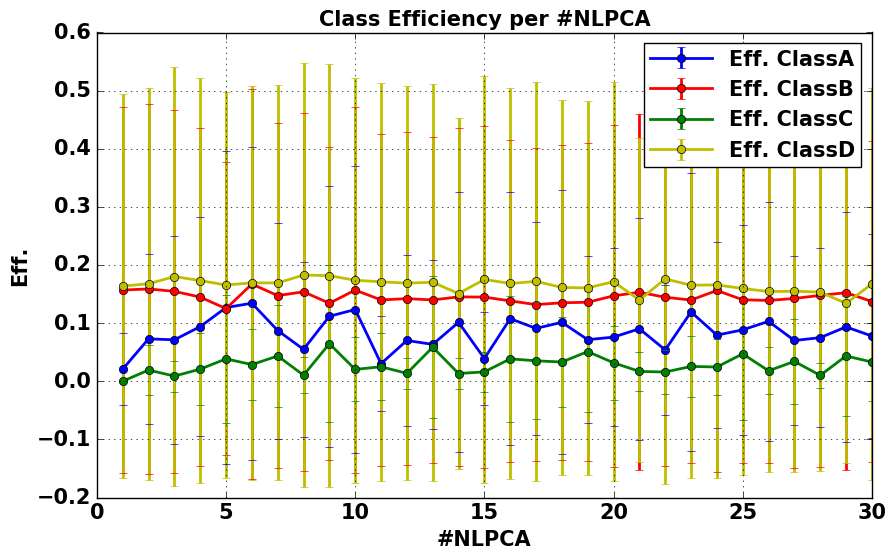

In [83]:
choose_date = '2016_09_21_20_56_00'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]


eff = np.zeros([4,train_info['n_folds'],train_info['n_nlpcas']])

for inlpca in range(train_info['n_nlpcas']):
    for ifold in range(train_info['n_folds']):
        if ifold > 1:
            continue
        for iclass, class_label in enumerate(class_labels):
            eff[iclass,ifold,inlpca] = results[ifold][inlpca][iclass,iclass]
            
            
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(10,6))
            
for iclass, class_label in enumerate(class_labels):
    plt.errorbar(range(train_info['n_nlpcas'])+np.ones_like(range(train_info['n_nlpcas'])),
                 np.mean(eff[:,:,:],axis=1)[iclass,:],
                 np.std(eff[:,:,:],axis=1)[iclass,:],
                 color=m_colors[iclass],linewidth=2.0,
                 label='Eff. %s'%(class_labels[iclass]),
                 fmt='-o')
    
plt.grid()
plt.legend(loc='best')
plt.title('Class Efficiency per #NLPCA',fontweight='bold',fontsize=15)
plt.xlabel('#NLPCA',fontweight='bold',fontsize=15)
plt.ylabel('Eff.',fontweight='bold',fontsize=15)
    

In [80]:
ifold

2